In [7]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [8]:
env = WindyGridworldEnv()

In [9]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [33]:
def compute_action(env, action_probs):
    # sample from this action prob distribution
    rn = np.random.uniform()
    if rn <= np.max(action_probs):
        act = np.argmax(action_probs)
    else:
        while True:
            act = np.random.randint(0, env.action_space.n)
            if act != np.argmax(action_probs):
                break
    return act

In [34]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        # reset the environment for the episode, also initialize the length and ep reward to zero
        observation = env.reset()
        ep_length = 0
        ep_reward = 0
        
        # initialization of the action for the first step in the env
        # compute the action to execute
        act = compute_action(env, policy(observation))
        
        while True:
            # execute the action in the environment
            next_state, reward, done, _ = env.step(act)
            ep_reward += reward
            ep_length += 1
            
            # now sample the action for the next step as well
            next_act = compute_action(env, policy(next_state))
            
            # update the state action pair
            Q[observation][act] = Q[observation][act] + alpha * ((reward + discount_factor*Q[next_state][next_act]) - Q[observation][act])
            observation = next_state
            act = next_act
            if done:
                stats[0][i_episode] = ep_length
                stats[1][i_episode] = ep_reward
                break
    
    return Q, stats

In [35]:
Q, stats = sarsa(env, 200)

Episode 200/200.

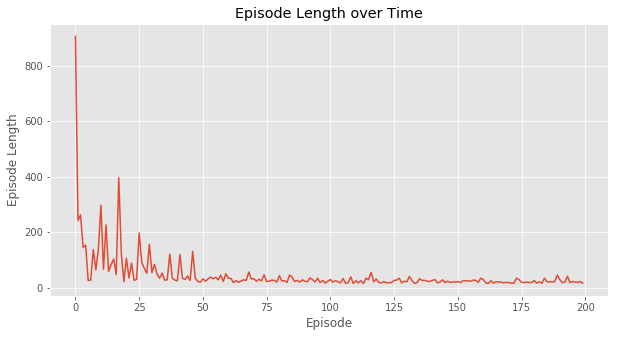

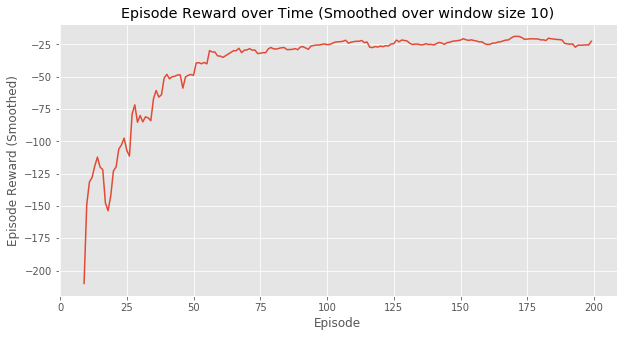

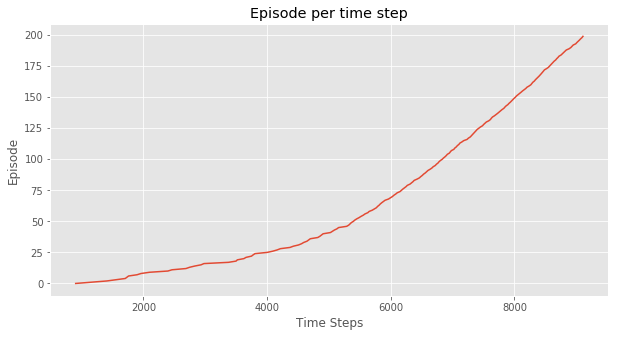

(<matplotlib.figure.Figure at 0x7f6969fd50b8>,
 <matplotlib.figure.Figure at 0x7f6969fa9828>)

In [36]:
plotting.plot_episode_stats(stats)